# Import Libraries

In [1]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import cv2

# Load Models

In [2]:
processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/home/nabil/miniconda3/envs/huggingface/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/nabil/miniconda3/envs/huggingface/lib/python3.8/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


# Load Test Images

In [3]:
image = Image.open('Tryon Human Models/test2.jpg')
inputs = processor(images=image, return_tensors="pt")

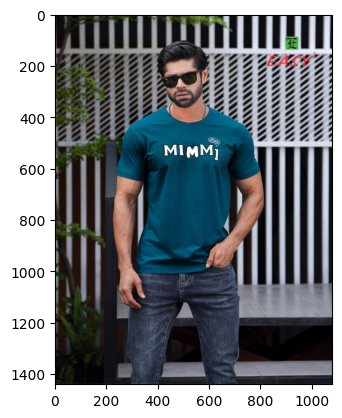

In [4]:
plt.imshow(image)

# Inferance

In [5]:
outputs = model(**inputs)
logits = outputs.logits.cpu()

In [6]:
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)
pred_seg = upsampled_logits.argmax(dim=1)[0]

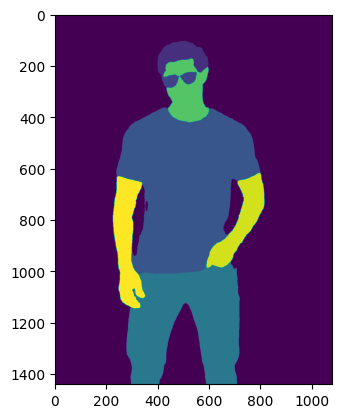

In [7]:
plt.imshow(pred_seg)

# Extract Upper Cloth Portion Only

In [8]:
pred_seg_cloth = pred_seg == 4

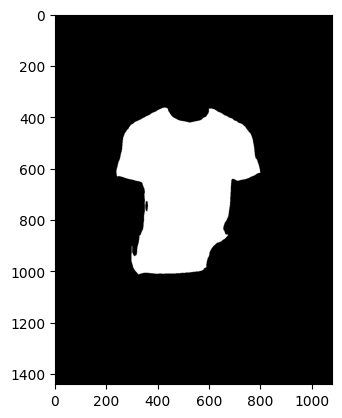

In [9]:
plt.imshow(pred_seg_cloth,cmap='gray')

# Convert Tensor Mask to Array Mask

In [10]:
mask = np.array(pred_seg_cloth)

In [11]:
white_pixels = np.argwhere(mask == True)

# Extract Cloth portion from RGB Image

In [12]:
y_min, x_min = white_pixels.min(axis=0)
y_max, x_max = white_pixels.max(axis=0)

In [13]:
# Convert Image to numpy image
image_np = np.array(image)
image_np = image_np[:, :, ::-1].copy()

In [14]:
# Convert BGR to RGB
image_rgb = cv2.cvtColor(image_np,cv2.COLOR_BGR2RGB)

In [15]:
# Crop image based on the mask
crop = image_rgb[y_min:y_max,x_min:x_max]

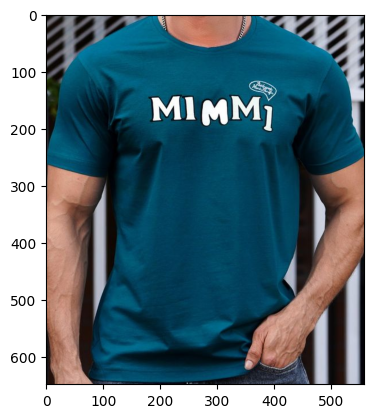

In [16]:
plt.imshow(crop)

# Masked Cropped Portion

In [17]:
mask_crop = mask[y_min:y_max,x_min:x_max]

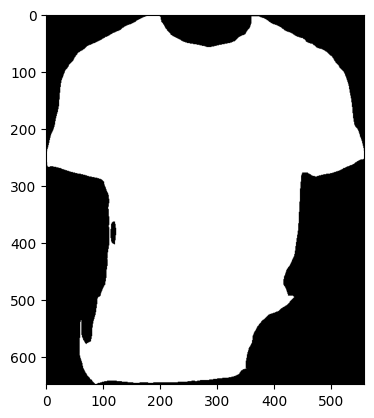

In [18]:
plt.imshow(mask_crop,cmap='gray')

# Load Preprocessed T-shirt Image

In [19]:
tshirt = cv2.imread('final_processed_tshirt.jpg')
tshirt = cv2.cvtColor(tshirt,cv2.COLOR_BGR2RGB)

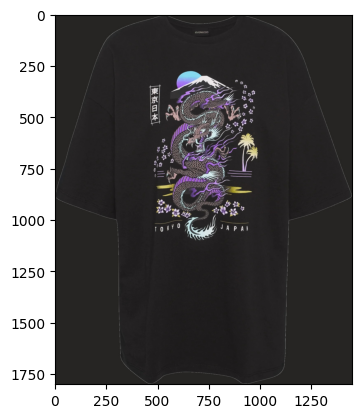

In [20]:
plt.imshow(tshirt)

In [21]:
mask_crop =np.where(mask_crop==False, 0,255)

# Overlay in the cropped portion

In [22]:
mask_image = Image.fromarray(mask_crop.astype('uint8'), 'L') 
tshirt_image = Image.fromarray(tshirt.astype('uint8'), 'RGB')  
crop_image = Image.fromarray(crop.astype('uint8'), 'RGB')  
tshirt_resized = tshirt_image.resize(crop_image.size, Image.LANCZOS)
final_image = Image.composite(tshirt_resized, crop_image, mask_image)

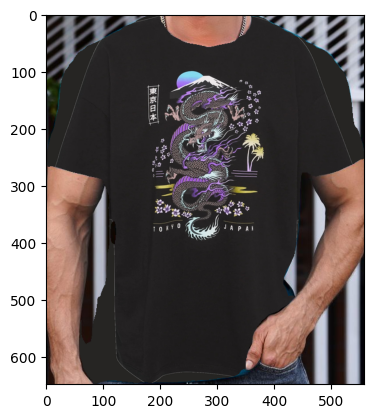

In [23]:
plt.imshow(final_image)

# Overlay in the Original Image

In [24]:
image_rgb[y_min:y_max,x_min:x_max] = final_image

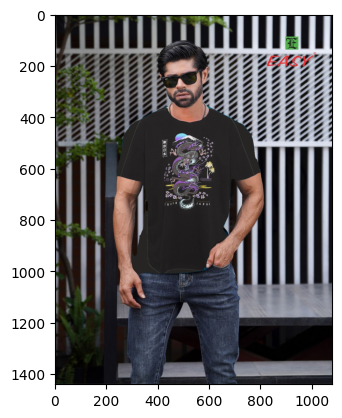

In [25]:
plt.imshow(image_rgb)

# Comparison

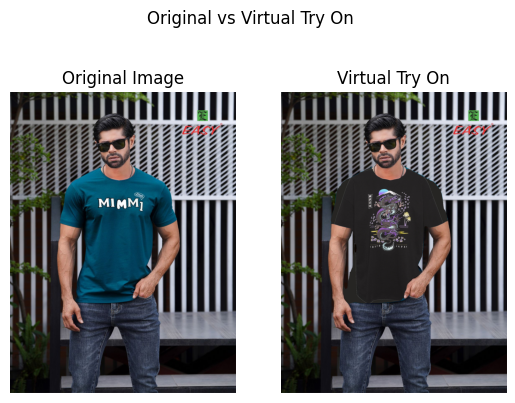

In [26]:
plt.subplot(1, 2, 1) 
plt.imshow(image)
plt.title('Original Image')
plt.axis('off') 

plt.subplot(1, 2, 2)
plt.imshow(image_rgb)
plt.title('Virtual Try On')
plt.axis('off') 

plt.suptitle('Original vs Virtual Try On') 
plt.savefig('assets/output.png') 
plt.show()
